- Title: My Contribution to Numpy
- Subtitle: Histograms, binwidth and the importance of communication
- Date: 2019-1-31 15:05
- Category: Open Source
- Tags: numpy, matplotlib, git, open-source
- Author: Varun Nayyar


Back in 2015, I was doing a lot of histogram plotting (as a result of MCMC) and was annoyed that I had to keep manually specifying the number of bins. At this stage I was somewhat versed with git (the 3 commands I needed, else delete and do a fresh checkout a la xkcd) and with numpy and non parametric statistics, so I decided to make a contribution. I first shopped this notebook to matplotlib, before being redirected to numpy.

The PR: https://github.com/numpy/numpy/pull/6029 was well recieved, but contributing to Open Source is an exercise of endurance, not much else. There was relentless bikeshedding that missed like 3 obvious bugs, something like 3 upstream changes that required me to deal with merge conflicts while we argued over my wording and the choice of function. I became very good with git rebase, reflog and dealing with pedantic reviewers. When I joined in HFT and was warned about harsh review, I remember asking after a month where the harsh reviews were, since I was yet to face one. 

It was a transformative experience for me - I credit it with transforming the way I thought about software. I went from a mathematician who could program into a proper software developer. I started writing tests for code I wrote, developed documentation before writing complex functions to allow me to think about code. Because of the experience, I spend time thinking about how someone will interact with my code and whinging about crappy one off functions that don't match the existing interface. I'm better for it and while it was traumatising for my first foray into open source, it remains one of my proudest achievments. Had I not been as drunk on my own success (as a uni student), I might never have had the confidence to throw a PR to numpy

One aspect of this process was how much communication was necessary. Once code enters an open source library, it's never going to leave - it needs support, careful api consideration and support when issues turn up. As a result, it's important to make a strong argument for these methods. What was self-evident for me, needed a concise argument and this is the notebook that I submitted to matplotlib and numpy: 

## Automating Binwidth for np.histogram

When using any kind python visualisation library that uses numpy for it's histogram, the main problem I face is the fact that the number of bins are not dynamically chosen, and in fact default to 10 bins. So whether I have a 50 samples or 5 million samples, by default I have 10 bins. I have to experiment until I get something I like, I don't even get a half decent choice, like in R, nor are different methods avaiable for automatically choosing the binwidths.

For example

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot') #this should be in the matplotlib.__init__.py

In [2]:
def gen3peaks(numPoints):
    numPoints/=3
    x1 = np.random.randn(numPoints) * 15 + 100
    x2 = np.random.randn(numPoints) * 10 + 60
    x3 = np.random.randn(numPoints) * 5+ 140
    return np.hstack((x1,x2, x3))

# using 3 peaks for more features and also avoids 
# trap of getting good results with normal data

xbig = gen3peaks(9000)
xmed = gen3peaks(900)
xsmall = gen3peaks(90)

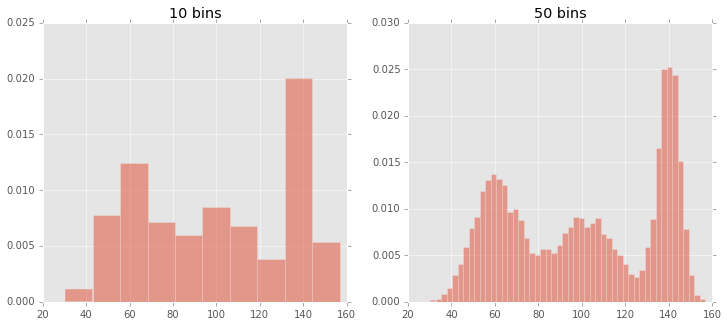

In [3]:
#reverse datasize order to get an idea of what the plot actually should look like
def quickHist(data):   
    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.hist(data, normed=True, alpha = 0.5)
    plt.title("10 bins")
    plt.subplot(122)
    plt.hist(data, normed=True, alpha = 0.5, bins = 50) # manual increase
    plt.title("50 bins")

# Large data set
quickHist(xbig)

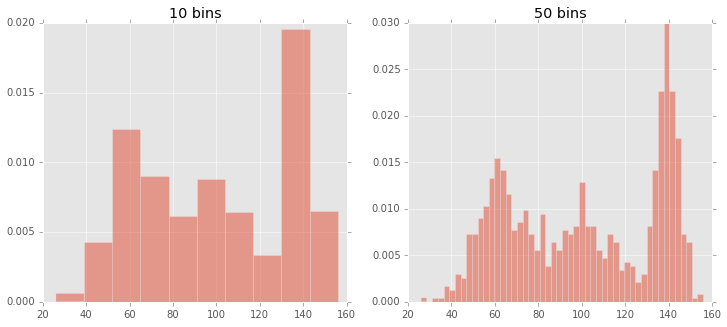

In [4]:
quickHist(xmed)

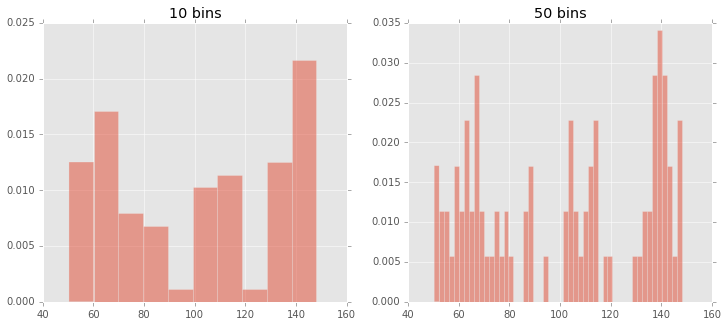

In [5]:
quickHist(xsmall)

In [6]:
#Using R in notebook, these next 3 cells will not operate without rpy2 installed
%load_ext rpy2.ipython

In [7]:
%R -i xbig,xsmall,xmed

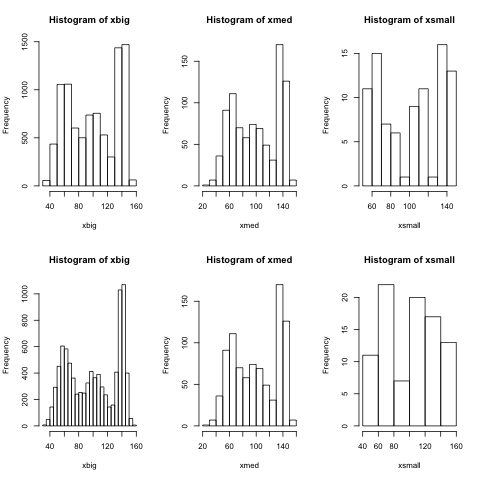

In [8]:
%%R
par(mfrow=c(2,3))
hist(xbig);
hist(xmed);
hist(xsmall);
#second row is using the scott estimation
hist(xbig, 'scott');
hist(xmed, 'scott');
hist(xsmall, 'scott');
#sorry about the shit plot - fig size control is iffy

It is obvious that R is clearly adapting to the amount and the type of data being passed in (even giving options for the automatic bin selection). It should be noted that R has a `pretty` method that interferes a little bit, making the sections start on whole numbers, with preference given to multiples of 2 and 5 and some freedom to increase or decrease the number of bins. Either way, the hist method that R provides gives us better functionality out of the box.

## Solution

Provide some kind of similar functionality for hist, taking inspiration from R's methods. Pretty can be implemented at a later stage if necessary. The focus here is to provide at least some kind of adaptability for the hist method.

* n = size of data
* h = binwidth
* Number of bins $\propto 1/h$
* The $\left\lceil f(x) \right\rceil$ mean the ceiling of the function

It is a known fact that the asymptotically optimal number of bins is proportional to $n^{1/3}$, which is the motivating reason behind the $n^{1/3}$ in the expressions below (binwidth ~ $n^{-1/3}$). This project been motivated by my study of non-parametrics at university.

We implement 5 methods here:

1. Sturges - default method in R
    * Number of Bins = $\left\lceil \log _{2}n+1 \right\rceil$
    * O(1) estimation
    * This method is considered to be too conservative for large datasets (the log grows too slowly), and is designed with the assumption of normality, which is commonly violated.
2. Rice - Sturges alternative
    * Number of Bins = $\left\lceil 2n^{-1/3} \right\rceil$
    * O(1) estimation
    * This method follows the asymptotic normality idea, but the constant 2 means it tends to make no allowance for data variability.
3. Sturges Rice Average
    * Number of Bins = mean(Sturges, Rice)
        * I've chosen the geometric mean, but arithmetic mean works since the number of bins is usually quite small
    * O(1) estimation
    * Provides decent results for smaller data
4. Scott - provided method in R
    * Binwidth = $\frac{3.5\sigma}{n^{-1/3}}$ 
    * if the binwidth is estimated to be 0, then return 1 as the number of bins
    * O(n) estimation
    * Uses the standard deviation of the data to account for data variabilty when choosing the number of bins.
    * The cube root factor means this method provides decent results for large amounts of data.
5. Freedman Diaconis - provided method in R
    * Binwidth = $2 \frac{IQR}{n^{-1/3}}$ 
    * If Inter Quartile Range (IQR) is 0, then use the Median Absolute Deviation instead as IQR. If it too is 0, return 1
    * O(n) estimation (percentile may be $O(log_2 n)$ but the range is O(n)
    * The IQR is a more robust estimator of variance than the standard deviation of the Scott estimator, which is more vulnerable to outliers.



## Further Reading/ Resources
* [This fairly thorough summary](http://www.stat.rice.edu/~scottdw/stat550/HW/hw3/c03.pdf) of histogram methods and some analysis from Rice's stats department.
* [R page](https://stat.ethz.ch/R-manual/R-devel/library/grDevices/html/nclass.html) on the included methods for automatic bin numbers. Note, that opening up an R console and typing nclass.Sturges (or scott, FD) will output the code. The publication references are provided in this page.
* [R page](https://stat.ethz.ch/R-manual/R-devel/library/graphics/html/hist.html) on histograms
* [Wikipedia](http://en.wikipedia.org/wiki/Histogram#Number_of_bins_and_width) for an overview of the methods and a simple argument for the optimality of $n^{1/3}$ for number of bins

In [9]:
def min8decorator(func):
    """"
    Decorate the estimators in case we need to provide a lower bound
    
    @min8decorator
    def func():
        ...
    """
    def inner(*args, **kwargs):
        return max(func(*args, **kwargs), 8)
    return inner

def minNdecorator(N):
    """"
    Decorate the estimators in case we need to provide a lower bound
    The minimum value can be defined as so
    @minNdecorator(10)
    def func():
        ...
    """
    def decorator(func):
        def inner(*args, **kwargs):
            return max(func(*args, **kwargs), N)
        return inner
    return decorator

def sturges(x):
    """
    Using Sturges estimator
    Very simplistic based on logarithms, however 
    poorer performance for large datasets and non-normal data
    """
    return np.ceil(np.log2(x.size)) + 1

def rice(x):
    """
    A similar version of sturges with another simple estimator. 
    Better performance for larger datasets
    The number of bins is proportional to the cube root of data size
    """
    return np.ceil(2 * len(x) ** (1.0/3))


def SturgesRice(x, geom= True):
    """
    An average or the Rice and Sturges - works surprisingly well in practice
    """
    if geom:
        #geometric mean
        return np.ceil(np.sqrt(rice(x) * sturges(x)))
    else:
        #arithmetic Mean
        return np.ceil((rice(x) + sturges(x))/2)

def scott(x):
    """
    The binwidth is proprtional to the standard deviation of the data and 
    inversely proportional to the cube root of data size
  
    """
    h = 3.5 * x.std() * x.size **(-1.0/3)
    if h>0:
        return np.ceil(x.ptp()/h)
    return 1

def mad(data, axis=None):
    """
    Mean Absolute Deviation - simple well defined function
    Simplest implementation, even length case left to default behaviour
    """
    return np.median(np.absolute(data - np.median(data, axis)), axis)

def FD(x):
    """
    Freedman Diaconis rule using IQR for binwidth
    Considered a variation of the Scott rule with more robustness as the Interquartile range
    is less affected by outliers than the standard deviation.
    
    If the IQR is 0, we return the median absolute deviation as defined above, else 1
    """
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    
    
    if iqr ==0: #unlikely
        iqr = mad(x) # replace with something useful
    
    h = (2 * iqr * x.size**(-1.0/3)) # binwidth
    
    if iqr > 0:
        return np.ceil(x.ptp()/h)

    return 1 #all else fails
                       
autoMethods = [sturges, rice, SturgesRice, scott, FD]

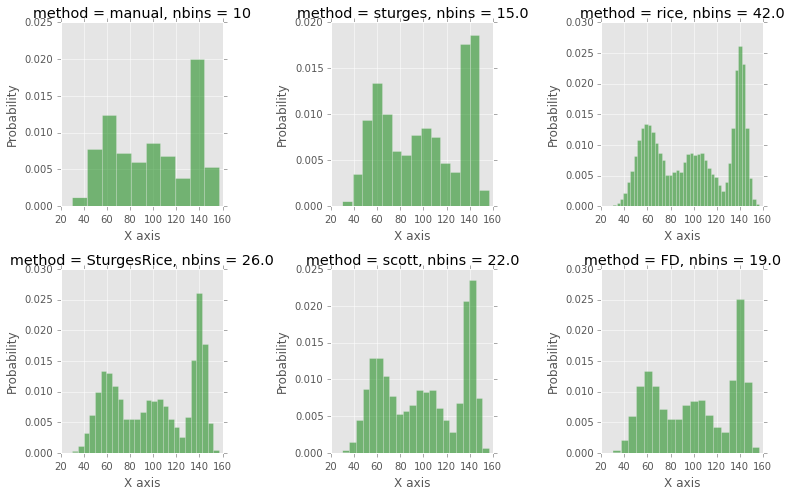

In [16]:
def methodDisplay(x, manual = 10):
    """
    Let's have a look at how our methods fare?
    """

    num_bins = [manual] + map(lambda method: method(x), autoMethods)
    bindesc = ["manual"] + map(lambda method: method.__name__, autoMethods[:-2]) + ["scott", "FD"] 
    # Using decorators means this trick doesn't work anymore

    plt.figure(tight_layout=True, figsize=(11,7))


    for i in range(len(bindesc)):
        binChoice = num_bins[i]
        desc = bindesc[i]
        plt.subplot(2,3,i+1)
        # the histogram of the data
        n, bins, patches = plt.hist(x, binChoice, normed=1, facecolor = 'green', alpha=0.5)
        plt.xlabel('X axis')
        plt.ylabel('Probability')
        plt.title(r'method = {1}, nbins = {0}'.format(binChoice, desc))

        # Tweak spacing to prevent clipping of ylabel
        plt.subplots_adjust(left=0.15)
    plt.show()
                  
methodDisplay(xbig)

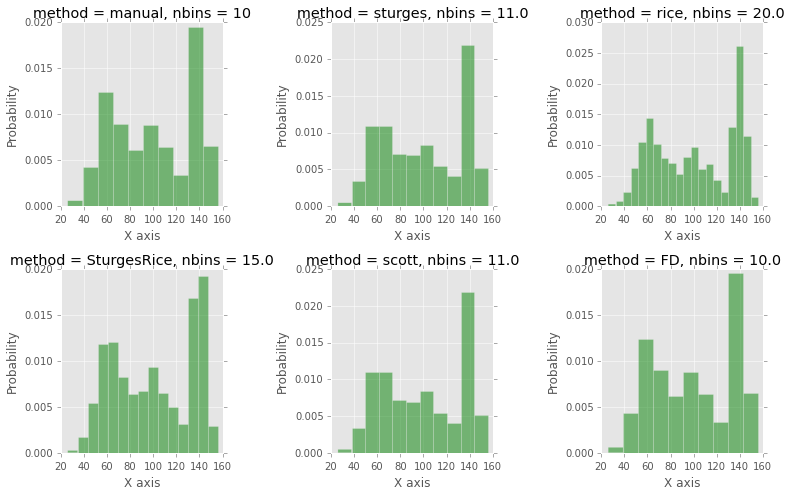

In [17]:
methodDisplay(xmed)

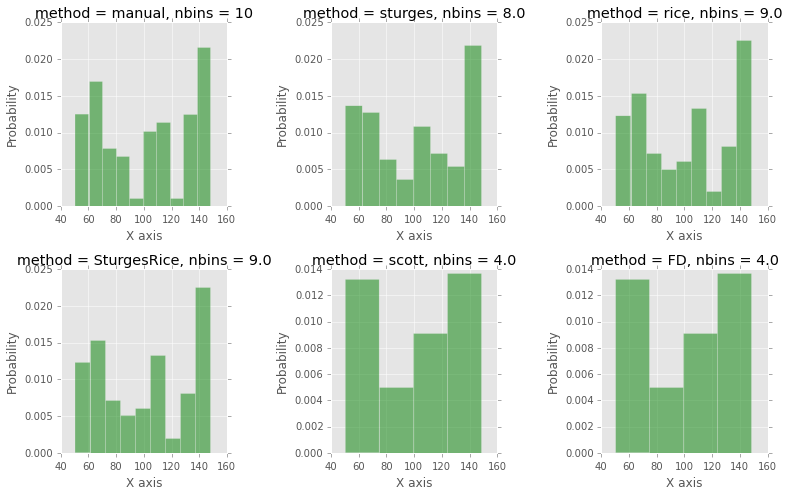

In [18]:
methodDisplay(xsmall)

## Conclusion

As a conclusion, I hope it's been quite obvious that the default 10 bins gives us a subpar solution for visualising the data. It provides decent results for data < 1000 samples, and makes no allowance for data variability. The other methods as discussed in literature and in R show much better performance, for larger datasets, and in fact anything over a 1000 datapoints will consistently use more than 10 bins to reveal the true nature of the data (play around with the sizes of xsmall, xmed and xbig to see).

Furthermore it is also noted
* Sturges' method is too conservative, especially for larger datasizes. 
* Rice's method is a bit too loose on it's estimation, showing significant noise in its bins.
* Sturges' and Rice's mean provides practically decent results for small datasets. 
* FD and scott also appear to very effective, but for small datasets tend to have very few bins chosen which may be less informative/optimal


## Recommendations
### Signature Change
I propose histogram's signature changes to

```python
def histogam(a, bins='optimal', ... )
"""
bins: integer, string, or array_like, optional
"""
```
* Default behaviour is to use the SturgesRice estimator for number of bins for x.size < 1000, else the Freeman Diaconis estimator. These functions attempt to estimate the optimal number of bins for the given data.
* You may use any of ['sturges', 'rice', 'SturgesRice', 'scott', 'FD'] as value of bins to choose between the different methods
* An integer ...
* An array like ...

This would allow all the visualisation libraries out there that depend on np.histogram to be able to get a somewhat optimal histogram as simply as passing 'FD' as the argument to bins.

There is also reason to pass a function for the bins argument, which automatically calculates the number of bins for the given data, however I'm unconvinced of it's necessity.

## Default
I would recommend providing a default method `'default'` of `max(Sturges(data), FD(data))` for visualisation libraries, as the FD tends to have subpar performance for small datasets, as the asymptotic optimality conditions haven't kicked in. The Sturges estimator provides an good enough value for small datasets, and the FD provides a good value that is bigger than the Sturges estimator for most cases where n>1000. 

From a statistics point of view, it would be great to have a good automatic bin choice when using a histogram function instead of manually playing around with the bins until we get a decent result. 